# Road image semantic segmentation
This model is created for autonomous robot ARBot. 



## Setup
This script must be run before another script.

In [ ]:
! pip install -q tensorflow-model-optimization

!nvidia-smi -L

from distutils.dir_util import copy_tree
import tensorflow_model_optimization as tfmot
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import cv2
import requests
from io import BytesIO
from PIL import Image
from tensorflow import keras
import json
import requests
from io import BytesIO
import os
import os.path
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import image_ops
import shutil


print(tf.__version__)

# Color image to label image conversion.
# image - RGB image
# idx - conversion definition, {(R, G, B): labelNum}, for eample:  {(0, 0, 0): 0, (128, 0, 0): 1}
# other - Label value used for colors not presented in idx
def LabelIndexImage(image, idx, other):
  res = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)
  res[:]=other
  for c in idx:
    res[(image==c).all(axis=2)] = idx[c]
    
  return res

# Loads images from file system.
# fn - images names
# imgDir - image directory 
# imgExt - image extenzion
# gtDir - label directory
# gtExt - label extenzion
# imgShape - desired image resolution
# gtShape - desired label resolution
# randomize - random augment  
# return - pairs image, label 
def load_images2(fn, imgDir, imgExt, gtDir, gtExt, imgShape, gtShape, randomize):
  fnImg=imgDir+fn+imgExt
  fnGt=gtDir+fn+gtExt

  image = tf.io.read_file(fnImg)
  if imgExt=='.bmp':
    image = tf.image.decode_bmp(image)
  else:
    image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  gt = tf.io.read_file(fnGt)
  gt = tf.image.decode_png(gt)

  if randomize:
    rndSize=(1+tf.random.uniform(()))/2
    rndXPos=(1-rndSize)*tf.random.uniform(())
    rndYPos=(1-rndSize)*tf.random.uniform(())
    ish = tf.dtypes.cast(tf.shape(image), tf.float32)
    gsh = tf.dtypes.cast(tf.shape(gt), tf.float32)
    image = tf.image.crop_to_bounding_box(image, tf.dtypes.cast(ish[0]*rndYPos, tf.int32), tf.dtypes.cast(ish[1]*rndXPos, tf.int32), tf.dtypes.cast(ish[0]*rndSize, tf.int32), tf.dtypes.cast(ish[1]*rndSize, tf.int32))
    gt = tf.image.crop_to_bounding_box(gt, tf.dtypes.cast(gsh[0]*rndYPos, tf.int32), tf.dtypes.cast(gsh[1]*rndXPos, tf.int32), tf.dtypes.cast(gsh[0]*rndSize, tf.int32), tf.dtypes.cast(gsh[1]*rndSize, tf.int32))

  image = tf.image.resize(image, imgShape, method='area')
  image = tf.slice(image, [0, 0, 0], [imgShape[0], imgShape[1], 3])
  gt = tf.image.resize(gt, gtShape, method='nearest')

  if randomize:
    # nahodne stranove prevratit
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      gt = tf.image.flip_left_right(gt)
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2) 
    # Random contast
    image = tf.image.random_contrast(image, lower=0.5, upper=1) 
    # Random saturation
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

  return image, gt

# Create dataset
# imgDir - image directory 
# imgExt - image extenzion
# gtDir - label directory
# gtExt - label extenzion
# imgShape - desired image resolution
# gtShape - desired label resolution
# randomize - random augment  
def datasetFromFilenames2(fn, imgDir, imgExt, gtDir, gtExt, imgShape, gtShape, randomize):
    ds=tf.compat.v2.data.Dataset.from_tensor_slices(fn)
    if randomize:
      ds = ds.repeat(1)

    ds1=ds.map(lambda dp:load_images2(dp, imgDir, imgExt, gtDir, gtExt, imgShape, gtShape, randomize) )
    return ds1

def create_mask(pred_mask):
  if pred_mask.shape[-1]!=1:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask            


# Download images from labelbox.com 
# uri - uri JSON od dataset definition
# imgDir - image folder
# gtDir - label folder
# idx 
# other 
def DownloadLabelBox(uri, imgDir, gtDir, idx, other):
  response = requests.get(uri)
  datasetJson=response.content

  js=json.loads(datasetJson)

  if not os.path.exists(imgDir):
    os.makedirs(imgDir)

  if not os.path.exists(gtDir):
    os.makedirs(gtDir)

  fn=[]
  for a in js:
    fn+=[a['External ID'].split('.')[0]]
    if not os.path.isfile(imgDir+a['External ID']):
      print(a['External ID'])
      response = requests.get(a['Labeled Data'])
      img = Image.open(BytesIO(response.content))
      img.save(imgDir+a['External ID'],'JPEG')

    #print(a['Label']['objects'])
      first=True
      for i in a['Label']['objects']:
        response = requests.get(i['instanceURI'])
        img = Image.open(BytesIO(response.content))
      #print(img.mode)
    
        if first:
          arr=np.asarray( img, dtype="uint8" )
          res = np.zeros(arr.shape).astype(np.uint8)
          res[...]=arr[...]
          first=False
        else:
          arr=np.asarray( img, dtype="uint8" )
          res[(res[:, :, 3]==0), :]=arr[(res[:, :, 3]==0), :]

      res=LabelIndexImage(res, idx, other)
      img=Image.fromarray(res)
      img.save(gtDir+os.path.splitext(a['External ID'])[0]+'.png','PNG')
  return fn

# Display images
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Probability ch. 0', 'Probability ch. 1']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if display_list[i].shape[-1]==1:
      n=display_list[i]
      if isinstance(display_list[i], tf.Tensor):
        n=n.numpy()
      s=n[:, :, 0].shape
      res=np.empty((s[0], s[1], 3), dtype=np.uint8)
      if(isinstance(n.dtype, np.float32)):
        res[:, :, 0]=0
        res[:, :, 1]=(n[:, :, 0]-min(n[:, :, 0]))*255/(max(n[:, :, 0])-min(n[:, :, 0]))
        res[:, :, 2]=0
      else:
        res[:, :, 0]=0
        res[:, :, 1]=n[:, :, 0]*255
        res[:, :, 2]=0
      plt.imshow(Image.fromarray(res))
    else:
      plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

# Calculates model accuracy
def ModelAccuracy(model, dataset):
  m=tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy', dtype=None)
  for image, mask in dataset:
    if len(image.shape)==3:
      pred_mask = model.predict(image[tf.newaxis, ...])
      if pred_mask.ndim==3:
        pred_mask=tf.concat([(1-pred_mask)[..., tf.newaxis], pred_mask[..., tf.newaxis]], 3) 
      m.update_state(mask, pred_mask[0]) 
    if len(image.shape)==4:
      pred_mask = model.predict(image)
      m.update_state(mask, pred_mask) 
  return m.result().numpy() 

# Save models frozen graph
def SaveFrozenGraph(model, path, suffix=''):
  full_model = tf.function(model).get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
  frozen_func = convert_variables_to_constants_v2(full_model)
  frozen_func.graph.as_graph_def()

  layers = [op.name for op in frozen_func.graph.get_operations()]

  print("-" * 50)
  print("Frozen model inputs: ")
  print(frozen_func.inputs)
  print("Frozen model outputs: ")
  print(frozen_func.outputs)

    # Save frozen graph from frozen ConcreteFunction to hard drive
  tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                      logdir=path+"/"+model.name+"/",
                      name="frozen"+model.name+suffix+".pb",
                      as_text=False)

# Generates images for model quantitization
def representative_data_gen():
  i=iter(train)
  for ii in range(100):
    image = next(i)[0]
    image = tf.expand_dims(image, 0)
    yield [image]

# Save model and quantuitized model in tflite format
def SaveTFLite(model, path):
  d=path+"/"+model.name
  if not os.path.exists(d):
    os.makedirs(d)

  cnv=tf.lite.TFLiteConverter.from_keras_model(model)
  cnv.optimizations=[tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
  #cnv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  #cnv.representative_dataset=representative_dataset_gen
  tflmodel=cnv.convert()
  open(d+"/"+model.name+".tflite", "wb").write(tflmodel)
    
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.experimental_new_converter = False
  # This enables quantization
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # This sets the representative dataset for quantization
  converter.representative_dataset = representative_data_gen
  # This ensures that if any ops can't be quantized, the converter throws an error
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  # For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
  converter.target_spec.supported_types = [tf.int8]
  # These set the input and output tensors to uint8 (added in r2.3)
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  tflite_model = converter.convert()

  open(d+"/"+model.name+"_int8.tflite", "wb").write(tflite_model)
    
def show_predictions(model, dataset, num=1):
  cnt=0;  
  for image, mask in dataset.take(num):
    print(cnt)
    cnt=cnt+1;
    if len(image.shape)==3:
      pred_mask = model.predict(image[tf.newaxis, ...])
      if pred_mask.ndim==3:
        pred_mask=pred_mask[...,tf.newaxis]
      if pred_mask.shape[3]==1:
        display([image, mask, create_mask(pred_mask)[0], pred_mask[0][...,0][...,tf.newaxis]])
      else:
        display([image, mask, create_mask(pred_mask)[0], pred_mask[0][...,0][...,tf.newaxis], pred_mask[0][...,1][...,tf.newaxis]])
    else:
      for i in range(image.shape[0]):
        pred_mask = model.predict(image[i][tf.newaxis, ...])
        if pred_mask.ndim==3:
          pred_mask=pred_mask[...,tf.newaxis]
        if pred_mask.shape[3]==1:
          display([image[i],
                  mask[i], 
                  create_mask(pred_mask)[0],
                  pred_mask[0][...,0][...,tf.newaxis]])
        else:
          display([image[i],
                  mask[i], 
                  create_mask(pred_mask)[0],
                  pred_mask[0][...,0][...,tf.newaxis],
                  pred_mask[0][...,1][...,tf.newaxis]])
    
class Trainer:
  def __init__(self, models, directory):
    self.history={}
    self.models=models
    self.directory=directory

  def Train(self, trainDS, testDS, epochs, disp):
    l=[]
    for m in self.models:
        checkpoint = tf.train.Checkpoint(model=m)
        mgr=tf.train.CheckpointManager(checkpoint, directory=self.directory+"/"+m.name, max_to_keep=5, keep_checkpoint_every_n_hours=1)
        if(mgr.latest_checkpoint!=None):
          checkpoint.restore(mgr.latest_checkpoint).expect_partial()
        l=l+[(m, checkpoint, mgr)]  

    for i in range(0, epochs):
      if disp:
        self.Disp()          
      for m, checkpoint, mgr in l:
        show_predictions(m, testDS, 1)
      print ('Epoch {}'.format(i+1))
      for m, checkpoint, mgr in l:
        print ('Model {}'.format(m.name))

        model_history = m.fit(trainDS, 
                          epochs=1,
                          validation_data=testDS
        )
        mgr.save()
        if m.name in self.history:
          for h in model_history.history:
            self.history[m.name][h]=self.history[m.name][h]+model_history.history[h]
        else:
          self.history[m.name]=model_history.history

        acc=t.history[m.name]['val_sparse_categorical_accuracy']
        if max(acc)==acc[len(acc)-1]:
            m.save(self.directory+'/'+ m.name+'/'+ m.name+'_'+str(acc[len(acc)-1])+'.h5')
            m.save_weights(self.directory+'/'+ m.name+'/'+ m.name+'_weights_'+str(acc[len(acc)-1])+'.h5')
 
      clear_output(wait=True)
  
  def Disp(self):
    acc='sparse_categorical_accuracy'
    plt.figure(figsize=(18, 10))
    for m in self.history:
      plt.plot(range(len(self.history[m][acc])), self.history[m][acc], label=m+'.accuracy')
      plt.plot(range(len(self.history[m]['val_'+acc])), self.history[m]['val_'+acc], label=m+'.val_accuracy')

    plt.title('Training results')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()



GPU 0: Tesla K80 (UUID: GPU-8cb0bee6-0ead-5cbf-0365-8e5121e0356c)
2.6.0


##Connect to the google drive



In [ ]:
# Connect to the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Prepare dataset


###Download dataset
One of download scripts must be run

####ARBot site
Download dataset from ARBot site.

In [ ]:
r = requests.get('http://www.arbot.cz/ds_train.zip', allow_redirects=True)
open('./ds_train.zip', 'wb').write(r.content)
#copy data set to the google drive
#shutil.copyfile('./ds_train.zip', '/content/gdrive/My Drive/ds_train.zip')

#unpack dataset 
shutil.unpack_archive('./ds_train.zip', './ds_train', 'zip')

####LabelBox
Download dataset from labelbox.

In [ ]:
fnARBot=DownloadLabelBox(
    'https://storage.googleapis.com/labelbox-exports/ck2iqtrgj3wn50757dxn4430t/ck2iqtrixgi6z08113jpu9imr/export-2020-11-29T08%3A18%3A04.502Z.json?GoogleAccessId=api-prod%40labelbox-193903.iam.gserviceaccount.com&Expires=1609181979&Signature=LEZin1GFAa%2F78%2FwCtkFbSHFzeP2bA59Z7tqsp1FcAwKBGLR5qo6sPK67QKPKpXxbYvQRPl9od43WGPYd5Vl9H5byQsMQUrE4DpJk%2FddrYa8xnDAsOpkch1OZ1gl%2BmCK0OIO8kKbb7zOu77yKxx2DolcFbDcsCKV8qBHOCo3%2FUienx7VutDsVsFbZW5uvaCaL6xXN%2FSKGPY6dmLC3XfifWYa7%2FwEwDTX4X2%2Fbpl5f2XNBz8T806Ndq0iS6UnkN%2BvfYxRqoj1k%2BXD0N%2BDRLLPp%2Bu78qGzg61oTO8FtuJo7akQpHiYidbouwZHKbjYW%2FGXESUZkSPyDy7UuHdTN9fU7oA%3D%3D&response-content-disposition=attachment'
    , './ds_train/img/', './ds_train/gt/', {(255, 255, 255, 255): 1}, 0)

#copy dataset to the google drive
#shutil.make_archive('./ds_train', 'zip', './ds_train/')
#shutil.copyfile('./ds_train.zip', '/content/gdrive/My Drive/ds_train.zip')

'/content/gdrive/My Drive/ds_train.zip'

#### Google drive
Download dataset from google drive.



In [ ]:
shutil.copyfile('/content/gdrive/My Drive/ds_train.zip', './ds_train.zip')
shutil.unpack_archive('./ds_train.zip', './ds_train', 'zip')

###Create dataset fron downloaded data


In [ ]:
fnARBot = [os.path.splitext(f)[0] for f in os.listdir('./ds_train/img') if os.path.isfile(os.path.join('./ds_train/img', f))]

resultDir='.'

#test images file names
fnTest=['mod_23_Right_Camera',
 '31',
 'mod_57_Right_Camera',
 'mod_29_Right_Camera',
 'rt_103',
 'mod_11_Right_Camera',
 'mod_64_Left_Camera',
 'rt_148',
 'mod_37_Right_Camera',
 'rt_126',
 'mod2_3_Left_Camera',
 'rt_28',
 'mod_24_Left_Camera',
 'rt_141',
 'mod2_22_Right_Camera',
 'HV2_20',
 'mod_77_Right_Camera',
 'rt_39',
 'mod_79_Left_Camera',
 'mod2_38_Right_Camera',
 'mod_48_Right_Camera',
 'HV2_68',
 'rt_19',
 'HV1_38',
 'HV2_38',
 'rt_160',
 'mod2_11_Right_Camera',
 'HV1_54',
 'mod_61_Right_Camera',
 'HV1_6',
 '46',
 'mod2_27_Right_Camera',
 'mod2_8_Right_Camera',
 'mod_62_Right_Camera',
 'mod_23_Left_Camera',
 'mod_51_Right_Camera',
 'rt_144',
 'rt_45',
 'rt_32',
 '36',
 'mod_1_Right_Camera',
 'HV2_35',
 'HV1_13',
 'mod2_6_Left_Camera',
 'mod_19_Left_Camera',
 'HV1_61',
 'rt_89',
 'rt_135',
 'mod_72_Right_Camera',
 'mod2_14_Right_Camera']
#fnTest=['mod_23_Right_Camera']

fnTrain=np.setdiff1d(fnARBot, fnTest)

    
shape=(128, 128)
# Red dataset

train=datasetFromFilenames2(fnTrain, './ds_train/img/', '.jpg', './ds_train/gt/', '.png', shape, shape, True)
train_steps = len(fnARBot)*1
train_dataset = train.shuffle(train_steps, reshuffle_each_iteration=True).batch(10)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test=datasetFromFilenames2(fnTest, './ds_train/img/', '.jpg', './ds_train/gt/', '.png', shape, shape, False)
test_steps=len(fnTest)
test_dataset = test.shuffle(test_steps, reshuffle_each_iteration=True).batch(1)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



# Model

This model is inspired by mobilenet and unet. There are many useful tips from the internet.  

* name - model name
* shape - input image shape. For RGB 96x96 use (96, 96, 3)
* outputs - number of outputs, for binary clasification 2
* expansion - expansion factor for each convolution block
* momentum - batch normalization momentum
* dropuotRate - dropout rate
* dtype - data type
* encoder - encoder structure, [[64, 64] [128]] - convolution blocks with 64 outputs, 64 output convolution block with downsaple to half resolution, 128 output convolution block with downsaple to half resolution
* decoder - decoder structure, [[64] [16, 16]] - upsampling, 64 output convolution block, upsampling, 2 convolution block with 16 outputs
* skips - generates skip layer for specific resolution level
* kernel - convolution kernel size





In [ ]:
def GenericModel(name, shape, outputs, expansion, momentum, dropoutRate, dtype, encoder, decoder, skips, kernel=3):
  if len(encoder)!=len(decoder):
    print('Lenght of encoder and decoder must be equal.')
    return

  if len(skips)!=len(decoder):
    print('Lenght of skips and decoder must be equal.')
    return

  reluMax=None
  useRelu=True
  activation=None

  size=(shape[0], shape[1])
    
  inputs = keras.Input(shape=shape, dtype=dtype, name='input')

  skip=[]
  ll=inputs

  for iii in range(len(encoder)):
    en=encoder[iii]
    skip=skip+[ll]  
    
    for ii in range(len(en)):
      i=en[ii]
    
      if ii==len(en)-1:
        strides=2
      else:
        strides=1
    
      print(strides)  
    
      prefix='encoder_{}_{}'.format(iii, ii)  

      ll=keras.layers.Dropout(dropoutRate, name=prefix+ '_expand_Dropout')(ll)
      ll=keras.layers.Convolution2D(i * expansion, 1, 1, padding='same', use_bias=False, activation=activation, name=prefix+ '_expand', dtype=dtype)(ll)
      ll=keras.layers.BatchNormalization(momentum=momentum, name=prefix+ '_expand_BN', dtype=dtype)(ll)
      if useRelu:
        ll=keras.layers.ReLU(reluMax, name=prefix+ '_expand_ReLU', dtype=dtype)(ll)
      ll=keras.layers.Dropout(dropoutRate, name=prefix+ '_depth_Dropout')(ll)
      ll=keras.layers.DepthwiseConv2D(kernel, strides, padding='same', use_bias=False, activation=activation, name=prefix+ '_depth', dtype=dtype)(ll)
      ll=keras.layers.BatchNormalization(momentum=momentum, name=prefix+ '_depth_BN', dtype=dtype)(ll)
      if useRelu:
        ll=keras.layers.ReLU(reluMax, name=prefix+ '_depth_ReLU', dtype=dtype)(ll)
      ll=keras.layers.Dropout(dropoutRate, name=prefix+ '_project_Dropout')(ll)
      ll=keras.layers.Convolution2D(i, 1, 1, padding='same', use_bias=False, activation=activation, name=prefix+ '_project', dtype=dtype)(ll)
      ll=keras.layers.BatchNormalization(momentum=momentum, name=prefix+ '_project_BN', dtype=dtype)(ll)
      last_i=i
    size=(size[0]/2, size[1]/2)

  print(size)

  for iii in range(len(decoder)):
    de=decoder[iii]
    size=(size[0]*2, size[1]*2)
    ll=keras.layers.UpSampling2D(size=(2, 2), name='decoder_{}_UpSampling'.format(iii))(ll)
    for ii in range(len(de)):
      i=de[ii]

      prefix='decoder_{}_{}'.format(iii, ii)  
    
      ll=keras.layers.Dropout(dropoutRate, name=prefix+ '_expand_Dropout')(ll)
      ll=keras.layers.Convolution2D(i * expansion, 1, 1, padding='same', use_bias=False, activation=activation, name=prefix+ '_expand', dtype=dtype)(ll)
      ll=keras.layers.BatchNormalization(momentum=momentum, name=prefix+ '_expand_BN', dtype=dtype)(ll)
      if useRelu:
        ll=keras.layers.ReLU(reluMax, name=prefix+ '_expand_ReLU', dtype=dtype)(ll)
      ll=keras.layers.Dropout(dropoutRate, name=prefix+ '_depth_Dropout')(ll)
      ll=keras.layers.DepthwiseConv2D(kernel, 1, padding='same', use_bias=False, activation=activation, name=prefix+ '_depth', dtype=dtype)(ll)
      ll=keras.layers.BatchNormalization(momentum=momentum, name=prefix+ '_depth_BN', dtype=dtype)(ll)
      if useRelu:
        ll=keras.layers.ReLU(reluMax, name=prefix+ '_depth_ReLU', dtype=dtype)(ll)
      ll=keras.layers.Dropout(dropoutRate, name=prefix+ '_project_Dropout')(ll)
      ll=keras.layers.Convolution2D(i, 1, 1, padding='same', use_bias=False, activation=activation, name=prefix+ '_project', dtype=dtype)(ll)
      ll=keras.layers.BatchNormalization(momentum=momentum, name=prefix+ '_project_BN', dtype=dtype)(ll)

    print(iii)

    if skips[len(decoder)-1-iii]:
      al=keras.layers.Dropout(dropoutRate, name=prefix+ '_conv_Dropout')(skip[len(decoder)-1-iii])
      al=keras.layers.Convolution2D(ll.shape[-1], 1, 1, padding='same', use_bias=False, activation=activation, name=prefix+ '_conv', dtype=dtype)(al)
      ll=keras.layers.Concatenate(axis=3, dtype=dtype, name=prefix+ '_concatenate')([ll, al])

  ll=keras.layers.Dropout(dropoutRate, name=prefix+ '_final_conv_Dropout')(ll)
  ll=keras.layers.Convolution2D(outputs, 1, 1, padding='same', use_bias=False, activation='sigmoid', name='final_conv', dtype=dtype)(ll)

  model = keras.Model(inputs=inputs, outputs=ll, name=name)
  
  #model = tfmot.quantization.keras.quantize_model(model)

  model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-7, learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  model.summary()  

  return model

model=GenericModel('Model61.1', (shape[0], shape[1], 3), 2, 1, 0.99, 0.2, 'float32', [[8, 16], [16, 32], [32, 64], [64, 128], [128, 128], [128, 256]], [[256, 128], [128, 128], [128, 64], [64, 32], [32, 16], [16, 16]], [False, False, True, True, True, True])




1
2
1
2
1
2
1
2
1
2
1
2
(2.0, 2.0)
0
1
2
3
4
5
Model: "Model61.1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_0_0_expand_Dropout (Dro (None, 128, 128, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
encoder_0_0_expand (Conv2D)     (None, 128, 128, 8)  24          encoder_0_0_expand_Dropout[0][0] 
__________________________________________________________________________________________________
encoder_0_0_expand_BN (BatchNor (None, 128, 128, 8)  32          encoder_0_0_expand[0][0]         
___________________________________________

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is losses.sparse_categorical_crossentropy. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.sparse_categorical_crossentropy is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

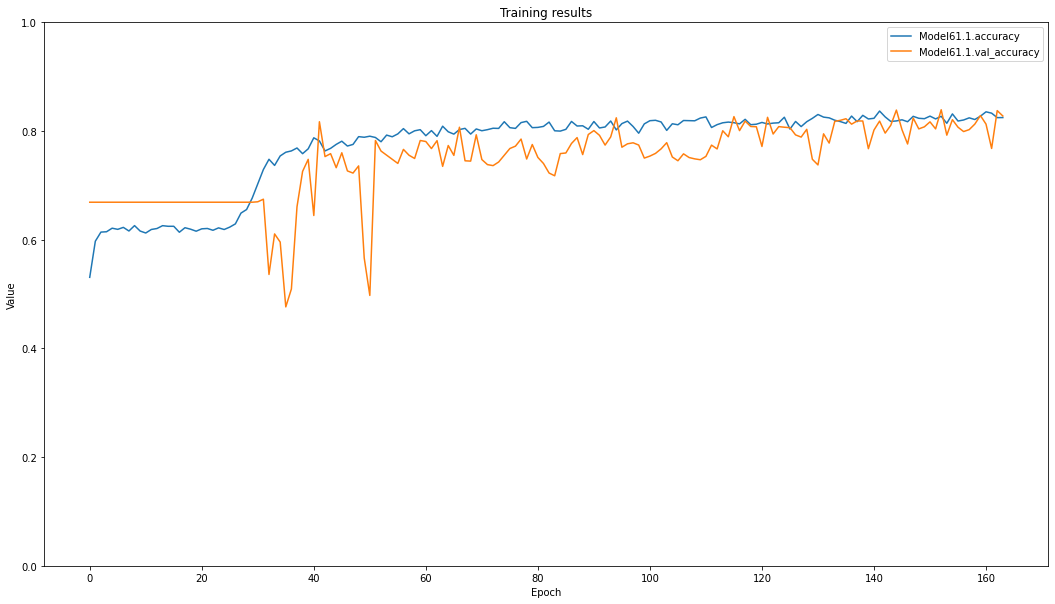

0


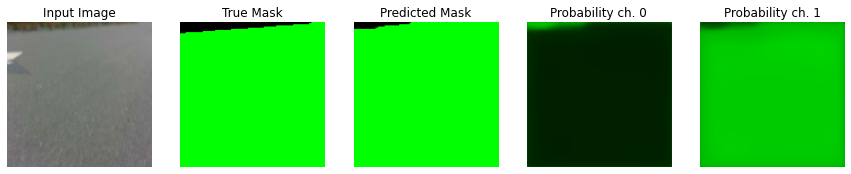

Epoch 165
Model Model61.1
49/54 [==========================>...] - ETA: 0s - loss: 0.3972 - sparse_categorical_accuracy: 0.8281

In [ ]:
t=Trainer([model], resultDir+'/models')
t.Train(train_dataset, test_dataset, 1200, True)
t.Disp()
print(ModelAccuracy(model, test_dataset))
show_predictions(model, train, 50)
SaveFrozenGraph(model, resultDir+'/models')
SaveTFLite(model, resultDir+'/models')
# copy result to google drive
#copy_tree(resultDir+'/models', '/content/gdrive/My Drive/models')


## Make predictions

In [ ]:
show_predictions(train, 50)